# Transport Bottlenecks in the CA1 model

In [1]:
%%bash
nrnivmodl # Compile NEURON code

Creating x86_64 directory for .o files.

/home/alex/Dropbox/Williams-etal-Synaptic-Transport/code/03
h.mod kadist.mod kaprox.mod kdrca1.mod km.mod na3n.mod naxn.mod vecevent.mod
h.mod kadist.mod kaprox.mod kdrca1.mod km.mod na3n.mod naxn.mod vecevent.mod
"/home/alex/neuron/nrn-7.4/x86_64/bin/nocmodl" h
"/home/alex/neuron/nrn-7.4/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/home/alex/neuron/nrn-7.4/include/nrn" -I"/home/alex/neuron/nrn-7.4/x86_64/lib"      -g -O2 -c -o h.lo h.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/home/alex/neuron/nrn-7.4/include/nrn -I/home/alex/neuron/nrn-7.4/x86_64/lib -g -O2 -c h.c  -fPIC -DPIC -o .libs/h.o
"/home/alex/neuron/nrn-7.4/x86_64/bin/nocmodl" kadist
"/home/alex/neuron/nrn-7.4/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/home/alex/neuron/nrn-7.4/include/nrn" -I"/home/alex/neuron/nrn-7.4/x86_64/lib"      -g -O2 -c -o kadist.lo kadist.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/home/alex/

Translating h.mod into h.c
Thread Safe
Translating kadist.mod into kadist.c
Thread Safe
Translating kaprox.mod into kaprox.c
Thread Safe
Translating kdrca1.mod into kdrca1.c
Thread Safe
Translating km.mod into km.c
Thread Safe
Translating na3n.mod into na3n.c
Thread Safe
Translating naxn.mod into naxn.c
Thread Safe
Translating vecevent.mod into vecevent.c
Notice: VERBATIM blocks are not thread safe


In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox
from neuron import h
import numpy as np
import pylab as plt
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.synapses import add_exp2
import time
%matplotlib inline
np.random.seed(123456789)

# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')

1.0

In [3]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
n = len(seg_list)

def make_utarg(func):
    uu = []
    for seg in seg_list:
        uu.append(func(dist_to_soma(seg)))
    uu = np.array(uu)
    return uu / np.sum(uu)

In [4]:
def get_deriv(params,utarg):
    # Parse params
    out = list(params[0:(n-1)])
    into = list(params[(n-1):2*(n-1)])
    
    # Matrices of linear system
    A = np.zeros((n,n))                     # "drift" -- trafficking/degradation
    B = np.concatenate(([1],np.zeros(n-1))) # "input" -- production at soma
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            # Out of parent, into child
            out_rate = out.pop()
            A[p,p] += -out_rate
            A[i,p] += out_rate
            # Into parent, out of child
            in_rate = into.pop()
            A[p,i] += in_rate
            A[i,i] += -in_rate
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                out_rate = out.pop()
                in_rate = into.pop()
                # Out of parent, into child
                A[i-1,i-1] += -out_rate
                A[i,i-1] += out_rate
                # Into parent, out of child
                A[i-1,i] += in_rate
                A[i,i] += -in_rate
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Return derivative based on trafficking rates
    return np.dot(A,utarg), A

def get_sys_matrix(x):
    in_rates = 1/(1+x**-1)
    out_rates = 1/(1+x)
    params = np.concatenate((out_rates,in_rates))
    mdot, A = get_deriv(params,utarg)
    return A

In [5]:
def set_transport_params(utarg):
    """
    Returns the ratio of parent/child concentration
    """
    # prepend to x because get_deriv pops from front
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

In [6]:
from scipy.linalg import expm  # matrix exponential used to solve linear system
from mpl_toolkits.mplot3d import Axes3D
from PyNeuronToolbox.morphology import shapeplot

#t0,dt = 200,1.1
t0,dt = 200,2
def run_sim():
    A = get_sys_matrix(set_transport_params(utarg))

    # initial condition, u starts only in soma and is trafficked out to dendrites
    u0 = np.zeros(n)
    u0[0] = sum(utarg)  # compartment 0 is the soma
    
    u = [np.dot(expm(100*A),u0)]
    t = [t0]
    while t[-1] < 20e4:
        t.append(t[-1]*dt)
        u.append(np.dot(expm(t[-1]*A),u0))
        
    u = np.array(u)
    err = np.linalg.norm((u - np.tile(utarg,(len(t),1))),ord=1,axis=1)
    
    return u,np.array(t),list(err)

def snapshot(i,clim=None):
    if clim is None: clim = [0,max(u[i,:])]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=u[i,:],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('t = '+str(t[-1]),fontweight='bold',fontsize=14)

    # colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    sm._A = []
    plt.colorbar(sm, shrink=0.5)
    plt.tight_layout()
    plt.axis('off')

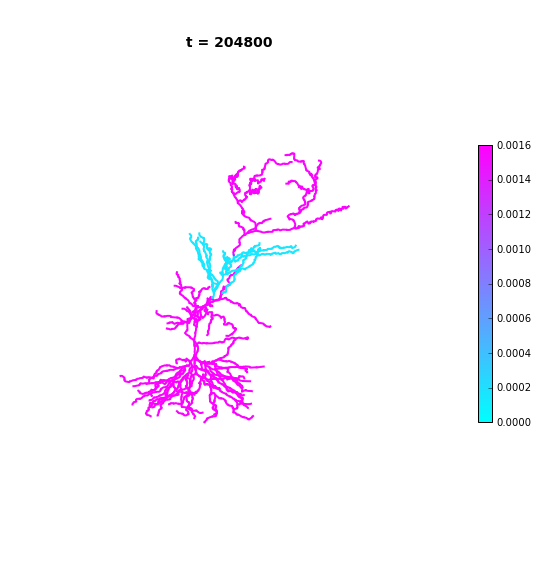

In [7]:
sim_data = {'t':[],'err':[],'u':[],'label':[]}

# Define bottleneck target distribution
utarg = np.ones(len(seg_list))
utarg[140:260] = 0.1
utarg /= np.sum(utarg)

# Keep the state matrix A, to do eigenvalue analysis
A_bottle = get_sys_matrix(set_transport_params(utarg))

# Simulate
u,t,err = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err'].append(err)
sim_data['label'].append('bottleneck')
snapshot(-1,clim=[0.0,0.0016])
#plt.savefig('bottleneck_ss.svg')

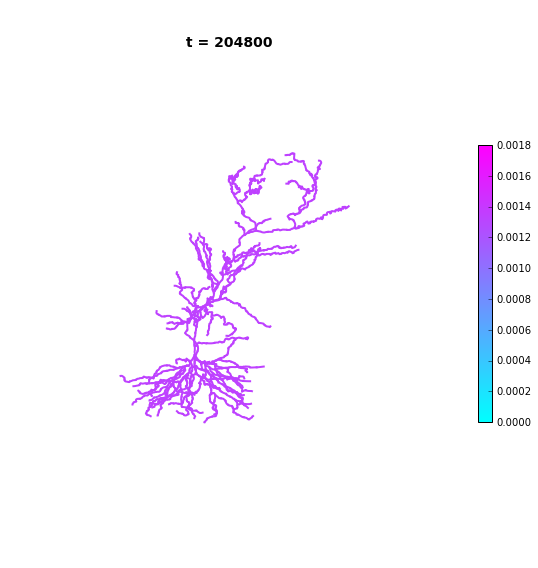

In [8]:
# Define uniform target distribution
utarg = np.ones(len(seg_list))
utarg /= np.sum(utarg)

# Keep the state matrix A, to do eigenvalue analysis
A_uniform = get_sys_matrix(set_transport_params(utarg))

# Simulate
u,t,err = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err'].append(err)
sim_data['label'].append('uniform')
snapshot(-1,clim=[0.0,0.0018])
#plt.savefig('uniform_ss.svg')

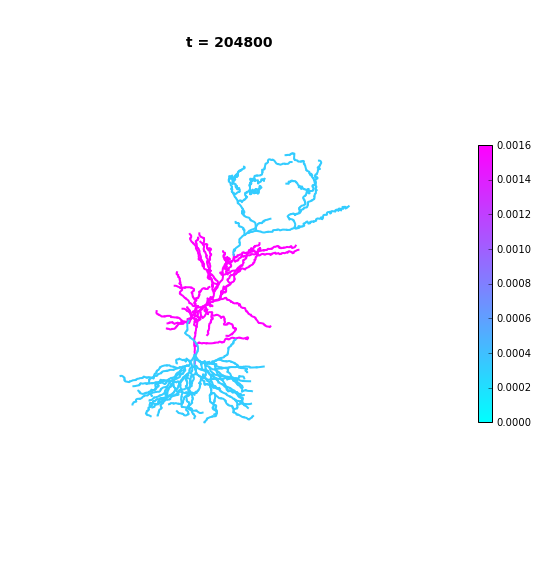

In [9]:
# Transport to Stratum Radiatum
utarg = 0.1*np.ones(len(seg_list))
utarg[:260] *= 10
utarg /= np.sum(utarg)

u,t,err = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err'].append(err)
sim_data['label'].append('SR')
snapshot(-1,clim=[0.0,0.0016])
#plt.savefig('SR_ss.svg')

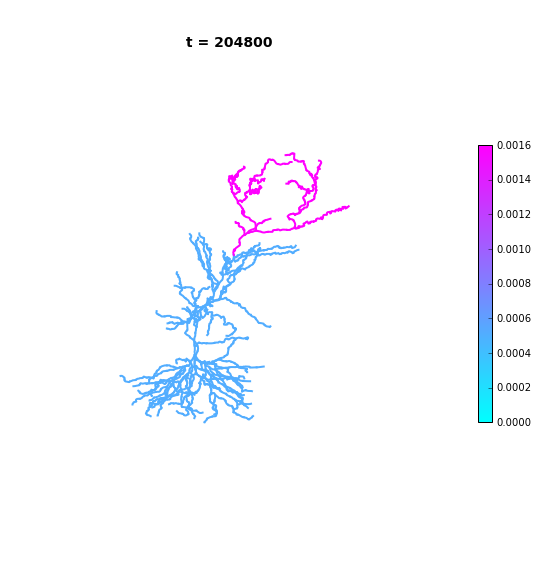

In [10]:
# Transport to Stratum Lacunosum/Moleculare
utarg = 0.1*np.ones(len(seg_list))
utarg[260:393] *= 10
utarg /= np.sum(utarg)

u,t,err = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err'].append(err)
sim_data['label'].append('SL/M')
snapshot(-1,clim=[0.0,0.0016])
#plt.savefig('SLM_ss.svg')

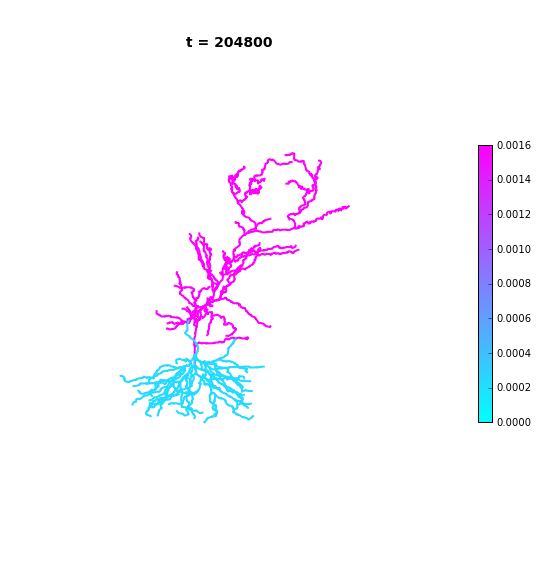

In [11]:
# Transport to Entire Apical Dendrite
utarg = 0.1*np.ones(len(seg_list))
utarg[:393] *= 10
utarg /= np.sum(utarg)

u,t,err = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err'].append(err)
sim_data['label'].append('both')
snapshot(-1,clim=[0.0,0.0016])
#plt.savefig('both_ss.svg')

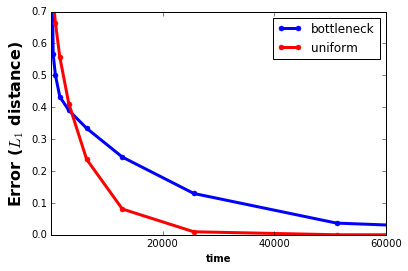

In [12]:
plt.figure()
ax = plt.subplot(111)
plt.plot(sim_data['t'][0],sim_data['err'][0],'.-b',label=sim_data['label'][0],markersize=10,lw=3)
plt.plot(sim_data['t'][1],sim_data['err'][1],'.-r',label=sim_data['label'][1],markersize=10,lw=3)
plt.ylim([0,0.7])
plt.xlim([t0,t[-3]])
plt.ylabel('Error ($L_1$ distance)',fontweight='bold',fontsize=16)
plt.xlabel('time',fontweight='bold')
plt.xlim([0,6e4])
plt.xticks([20000,40000,60000])
plt.legend()
#plt.savefig('panel_D.svg')
plt.show()

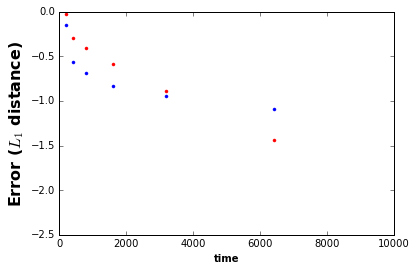

In [13]:
# Same as above, but on a log y-scale
plt.figure()
ax = plt.subplot(111)
plt.plot(sim_data['t'][0],np.log(sim_data['err'][0]),'.b',label=sim_data['label'][0],lw=3)
plt.plot(sim_data['t'][1],np.log(sim_data['err'][1]),'.r',label=sim_data['label'][1],lw=3)
plt.ylabel('Error ($L_1$ distance)',fontweight='bold',fontsize=16)
plt.xlabel('time',fontweight='bold')
plt.xlim([0,1e4])
plt.ylim([-2.5,0])
plt.show()

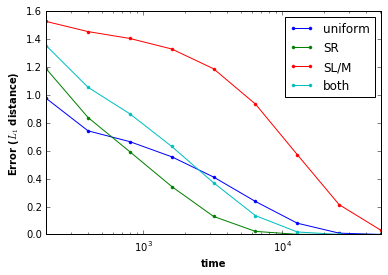

In [14]:
plt.figure()
ax = plt.subplot(111)
for i in range(1,len(sim_data['t'])):
    plt.plot(sim_data['t'][i],sim_data['err'][i],'.-',label=sim_data['label'][i])
plt.xlim([t0,t[-3]])
plt.ylabel('Error ($L_1$ distance)',fontweight='bold')
plt.xlabel('time',fontweight='bold')
plt.xscale('log')
plt.legend()
plt.show()

In [15]:
def segs_to_soma(seg_index):
    A = get_sys_matrix(set_transport_params(utarg)) # mass-action matrix
    Q = [0]        # Queue of segments (start at soma)
    found = False  # Flag to break search
    depth = 0      # Depth in tree
    j = 1          # Countdown to increase depth
    
    # Breadth-first search
    while not found:
        p = Q.pop(0)
        j -= 1
        if p == seg_index:
            found = True
        else:
            Q += list(np.where(A[p:,p]>0)[0]+p) # add new children
            if j == 0:
                depth += 1
                j = len(Q)
    return depth

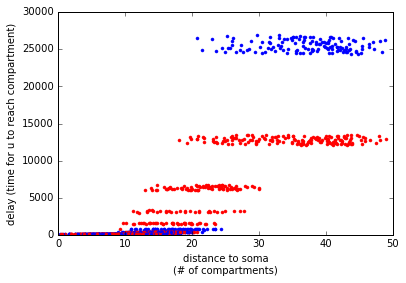

In [16]:
plt.figure()

cols = ['b','r']
for i in range(len(seg_list)):
    for a in np.random.permutation([0,1]):
        inds = np.where(sim_data['u'][a][:,i]>0.001)[0]
        if len(inds) == 0: continue
        j = inds[0] # time index for first crossing
        x = max([0,segs_to_soma(i) + np.random.uniform(-0.5,0.5)])
        y = sim_data['t'][a][j]*np.random.uniform(0.95,1.05)
        plt.plot(x,y,'.',color=cols[a])

plt.xlabel('distance to soma\n(# of compartments)')
plt.ylabel('delay (time for u to reach compartment)')
#plt.savefig('panel_E.svg')
plt.show()

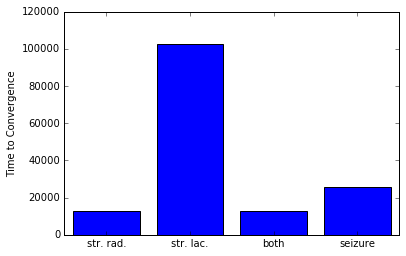

In [17]:
ct = [] # convergence times
N = len(sim_data['t'])-1
for i in [2,3,4,1]:
    inds = np.where(np.array(sim_data['err'][i]) < 0.02)[0]
    ct.append(sim_data['t'][i][inds[0]])
    
plt.figure()
plt.bar(np.arange(N)+0.6,ct)
plt.xticks(range(1,N+1),('str. rad.','str. lac.','both','seizure'))
plt.ylabel('Time to Convergence')
#plt.savefig('panel_F.svg')
plt.show()